In [1]:
%run -i "loaddata.py"
plt.style.use('seaborn-white')
plt.style.use('seaborn-ticks')
plt.rcParams["font.size"] = 13
import scipy.stats as st
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
np.random.seed(42)

What is your name? [Simone/Jonathan/Marcus/Runi]Jonathan


In [2]:
# Choose wisely
save = False
only_2_features=False
test_on = 1
scale = True

In [3]:
# Collect all data into 1 array
keys = tuple(data_dict.keys())[::2]

data = []
for key in keys:
    for vec in list(data_dict[key]):
        if not np.isnan(vec[0]) and (vec[:][3:]!=0).any():
            data.append(vec)
data = np.array(data)
print(data.shape)
features = data_dict[ list(data_dict.keys())[1] ]

(1568, 28)


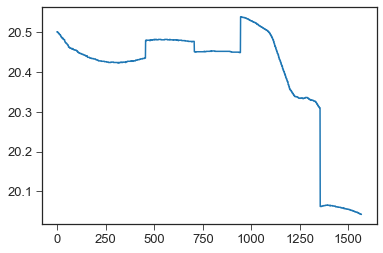

In [4]:
features[8], features[14]
plt.plot(data[:,8])

# All time series in a single plot

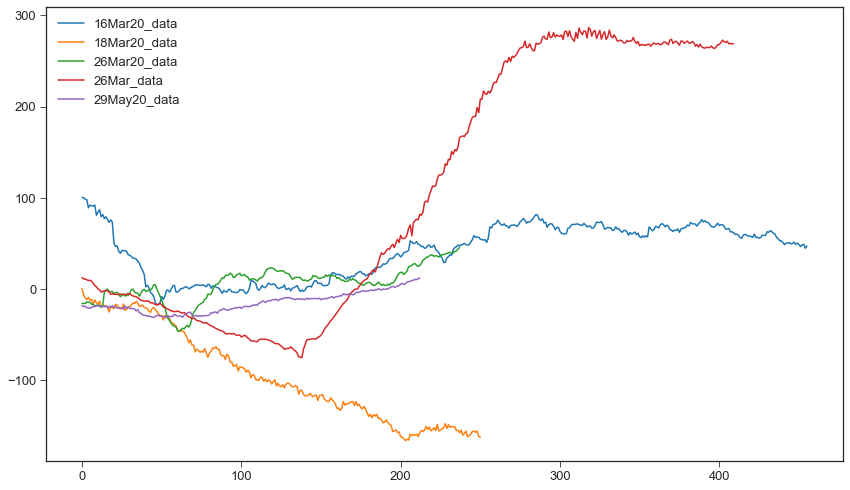

In [5]:
lengths = [len(data_dict[keys[i]]) for i in range(len(keys))]

plt.figure(figsize=(12,7))
for key in keys:
    plot_data = data_dict[key][:,1]
    plot_data = plot_data[np.isnan(plot_data) != True]
    plt.plot(plot_data, label=key)
plt.legend()
plt.tight_layout()
plt.show()

# sklearn time
## XGBoost

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data[:,3:], data[:,1], test_size=0.25)

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

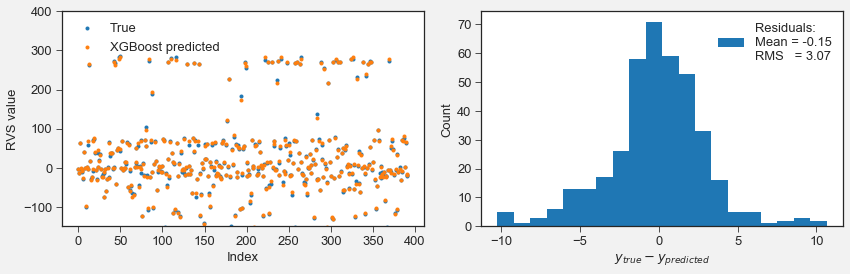

In [7]:
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(y_test, '.',label="True")
plt.plot(y_pred, '.', label="XGBoost predicted")
plt.ylim([-150, 400])
plt.xlabel("Index"); plt.ylabel("RVS value")
plt.legend()

mean = np.mean(y_test - y_pred)
rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))

plt.subplot(122)
plt.hist(y_test-y_pred, label=f"Residuals:\nMean = {mean:.2f}\nRMS   = {rms:.2f}", bins=20)
plt.ylabel("Count"); plt.xlabel("$y_{true} - y_{predicted}$")
plt.legend()
fig.patch.set_facecolor("#f2f2f2")
plt.tight_layout()
plt.show()

In [8]:
# fig.savefig("figs/sklearn_test_split_XGBoost.pdf",facecolor=fig.get_facecolor())

### New Split Shit

In [9]:
# 50/50 split
X_train, X_test = np.copy(data[ ::2, 3:]), np.copy(data[1::2, 3:])
y_train, y_test = np.copy(data[ ::2, 1 ]), np.copy(data[1::2, 1 ])

model = xgb.XGBRegressor()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)

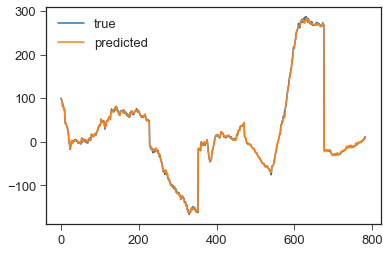

RMS = 2.654


In [10]:
plt.figure()
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### Predict 1 timeseries

In [11]:
# Clean and put into data_sort
data_sort = []
for key in keys:
    pre_data = []
    for i in range( len(data_dict[key]) ):
        if ( (data_dict[key][i,3:] != 0.).all() ) & ( (np.isnan(data_dict[key][i, :])!=True).all() ):
            pre_data.append( list(data_dict[key][i,:]) )
    data_sort.append(np.array(pre_data))
print("Shapes of different timeseries:",[i.shape for i in data_sort])

def test_1_timeseries( test_index , scaler=False):
    X_train = np.empty(( 0, data_sort[0].shape[1]-3))
    y_train = np.array([])
    for i in range(len(data_sort)):
        if i!=test_index:
            if scaler:
                scaler = StandardScaler()
                data_scaled = scaler.fit_transform(data_sort[i])
            else:
                data_scaled = data_sort[i]
            X_train = np.append(X_train, data_scaled[:,3:], axis=0)
            y_train = np.append(y_train, data_scaled[:,1])
    if scaler:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data_sort[test_index])
    else: 
        data_scaled = data_sort[test_index]
    X_test = data_scaled[:,3:]
    y_test = data_scaled[:,1]
    return X_train, X_test, y_train, y_test

Shapes of different timeseries: [(456, 28), (247, 28), (238, 28), (407, 28), (211, 28)]


(1312, 25) (247, 25) (1312,) (247,)


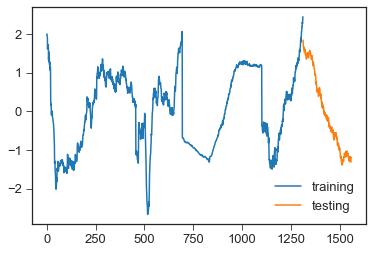

In [12]:
X_train, X_test, y_train, y_test = test_1_timeseries(test_on, scaler=scale)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# # Only two features
if only_2_features:
    X_train, X_test = X_train[:, [8-3, 14-3]], X_test[:, [8-3, 14-3]]
    print(X_train.shape, X_test.shape)

# Print figure
plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

### XGboost

In [13]:
# Fit
mlp = xgb.XGBRegressor()
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

In [14]:
# Create a model with no hyperparameters
clf_xgb = xgb.XGBRegressor(random_state = 42, n_jobs=4)

# Parameters to search
parameters_RandomSearch = {
    "n_estimators": st.randint(1,20),
    "max_depth": st.randint(1,20),
    "learning_rate": st.uniform()
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_xgb, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=42,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train)

# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.1s


Random Search: 	Best parameters:  {'learning_rate': 0.3500784076946757, 'max_depth': 1, 'n_estimators': 15} , Best scores: -0.7177


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.7s finished


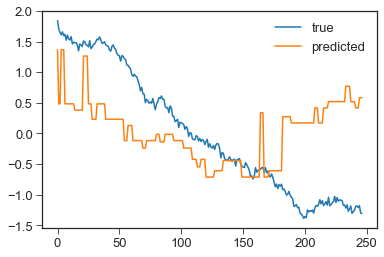

RMS = 1.001


In [15]:
y_pred = RandomSearch.predict(X_test)

plt.figure()
plt.plot(y_test,label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

### Bayesian Optimization

In [16]:
from bayes_opt import BayesianOptimization
def xgboost_CrossValidation(num_round, eta, max_depth, data, targets):
    """Decision Tree cross validation.
       Fits a Decision Tree with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
    """
    
    estimator = xgb.XGBRegressor(random_state=42, 
                                  num_round=num_round,
                                  eta=eta,
                                  max_depth=max_depth)
    
    cval = cross_val_score(estimator, data, targets, cv=5)
    
    return cval.mean()

def optimize_xgboost(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(num_round, eta, max_depth, data=data, targets=targets):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        return xgboost_CrossValidation(max_depth=int(max_depth), 
                                       num_round=int(num_round),
                                       eta=eta,
                                       data=data, 
                                       targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=42, 
                                     verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

In [17]:
parameters_BayesianOptimization = {"max_depth": (1, 20), 
                                   "num_round": (1, 20),
                                   "eta": (0,1)
                                  }

BayesianOptimization = optimize_xgboost(data = X_train, 
                                        targets = y_train, 
                                        pars = parameters_BayesianOptimization, 
                                        n_iter=100)
print(BayesianOptimization.max)

|   iter    |  target   |    eta    | max_depth | num_round |
-------------------------------------------------------------
|  1        | -0.07131  |  0.3745   |  19.06    |  14.91    |
|  2        | -0.08628  |  0.5987   |  3.964    |  3.964    |
|  3        | -0.08104  |  0.05808  |  17.46    |  12.42    |
|  4        |  0.1814   |  0.7081   |  1.391    |  19.43    |
|  5        | -0.4032   |  0.0      |  1.0      |  20.0     |
|  6        | -0.1334   |  1.0      |  3.437    |  16.44    |
|  7        | -0.04375  |  1.0      |  6.9      |  20.0     |
|  8        | -0.0434   |  0.2987   |  14.41    |  2.442    |
|  9        |  0.08369  |  1.0      |  10.59    |  8.525    |
|  10       |  0.05646  |  1.0      |  11.21    |  14.27    |
|  11       | -0.05494  |  0.376    |  14.0     |  19.9     |
|  12       |  0.09388  |  1.0      |  20.0     |  5.7      |
|  13       |  0.3471   |  0.1077   |  1.036    |  9.587    |
|  14       | -0.4032   |  0.0      |  5.507    |  10.07    |
|  15   

|  81       | -0.4032   |  0.0      |  5.12     |  2.518    |
|  82       |  0.0759   |  1.0      |  9.68     |  15.64    |
|  83       |  0.09013  |  1.0      |  15.74    |  20.0     |
|  84       |  0.07017  |  1.0      |  1.0      |  20.0     |
|  85       | -0.1334   |  1.0      |  3.03     |  1.0      |
|  86       | -0.2941   |  1.0      |  2.327    |  18.43    |
|  87       | -0.5095   |  0.8905   |  3.317    |  14.58    |
|  88       | -0.1745   |  0.9829   |  5.504    |  17.39    |
|  89       |  0.1107   |  0.02083  |  6.753    |  13.65    |
|  90       |  0.06348  |  0.01901  |  16.37    |  9.117    |
|  91       | -0.4032   |  0.0      |  13.08    |  12.96    |
|  92       | -0.08039  |  0.06616  |  11.87    |  1.018    |
|  93       |  0.08933  |  1.0      |  18.31    |  5.016    |
|  94       | -0.009219 |  0.02548  |  16.51    |  2.677    |
|  95       | -0.08498  |  1.0      |  5.763    |  14.8     |
|  96       |  0.0759   |  1.0      |  9.247    |  13.79    |
|  97   

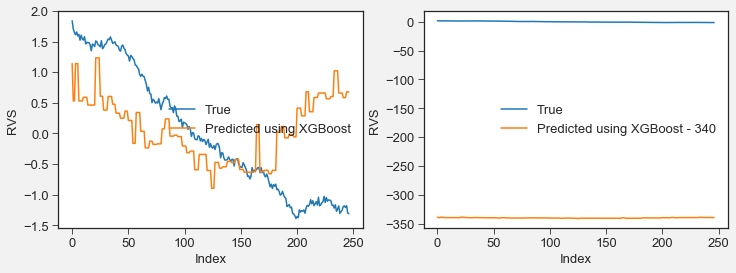

RMS = 1.012


In [18]:
model = xgb.XGBRegressor(eta = BayesianOptimization.max["params"]["eta"],
                          max_depth =int(BayesianOptimization.max["params"]["max_depth"]),
                          num_round = int(BayesianOptimization.max["params"]["num_round"]), 
                          random_state=42)

model.fit(X_train, y_train)

# make predictions for test data
y_pred_xg = model.predict(X_test)#+155

# evaluate predictions
fig = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(y_test,label="True")
plt.plot(y_pred_xg, label="Predicted using XGBoost")
plt.xlabel("Index"); plt.ylabel("RVS")
plt.legend(loc="center right")
plt.subplot(122)
plt.plot(y_test,label="True")
plt.plot(y_pred_xg -340, label="Predicted using XGBoost - 340")
plt.xlabel("Index"); plt.ylabel("RVS")
fig.patch.set_facecolor("#f2f2f2")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred_xg)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

In [19]:
# fig.savefig(f"figs/bad_test_{test_on+1}_XGBoost.pdf", facecolor=fig.get_facecolor())

## NN

In [20]:
# 50/50 split
X_train, X_test = np.copy(data[ ::2, 3:]), np.copy(data[1::2, 3:])
y_train, y_test = np.copy(data[ ::2, 1 ]), np.copy(data[1::2, 1 ])

# Scale in order to 
scaler = StandardScaler()

# Fit only to the training data
scaler.fit(X_train)

# Now apply the transformations to the data:
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [21]:
mlp = MLPRegressor(hidden_layer_sizes=(15, 14), max_iter=2000)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


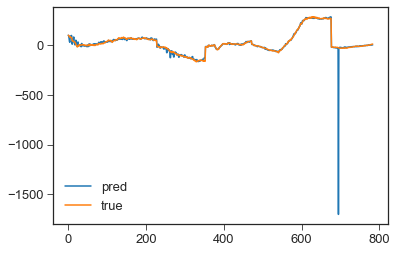

In [22]:
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### CV random search

In [23]:
# Create a model with no hyperparameters
clf_NN = MLPRegressor(learning_rate = 'adaptive', solver='adam', early_stopping=True, max_iter=1000)

class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu"],#, "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=3),
    "learning_rate_init": st.uniform()
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_NN, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=42,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   42.0s finished


In [24]:
# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (82, 62, 29), 'learning_rate_init': 0.2713490317738959} , Best scores: -54.5485


56.393057889432924


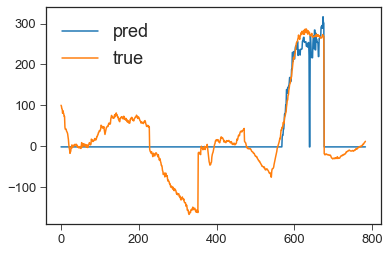

In [25]:
y_pred = RandomSearch.predict(X_test)
rms = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_test))
print(rms)
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend(fontsize=(18))
plt.show()

### Predict one timeseries

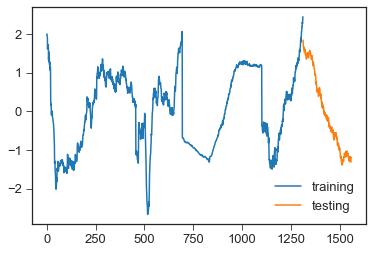

In [26]:
X_train, X_test, y_train, y_test = test_1_timeseries(test_on, scaler=scale)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Remove to only 2 features
if only_2_features:
    X_train, X_test = X_train[:, [8-3, 14-3]], X_test[:, [8-3, 14-3]]

# Plot
plt.figure()
x0 = np.arange(0, len(y_train),1)
x1 = np.arange(len(y_train), len(y_train)+len(y_test),1)
plt.plot(x0, y_train,label="training")
plt.plot(x1, y_test, label="testing")
plt.legend()
plt.show()

In [27]:
seed = 591
np.random.seed(seed)
# Fit
mlp = MLPRegressor(hidden_layer_sizes=(24,23), max_iter=2000, random_state=seed)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

# Test
mlp = MLPRegressor(hidden_layer_sizes=(24,23), max_iter=2000, random_state=seed)
ind = np.arange(0, X_train.shape[0], 1)
np.random.shuffle(ind)
X_train2 = X_train[ind, :]
print(X_train.shape, X_train2.shape)
mlp = MLPRegressor(hidden_layer_sizes=(24,23), max_iter=2000)
mlp.fit(X_train2, y_train)

y_pred_other = mlp.predict(X_test)

(1312, 25) (1312, 25)


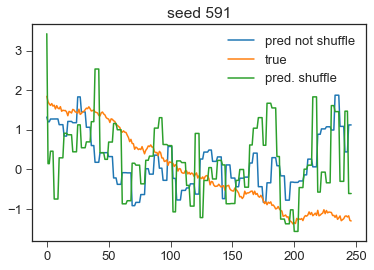

In [28]:
# Plotting
plt.figure()
plt.title(f"seed {seed}")
plt.plot(y_pred,label="pred not shuffle")
plt.plot(y_test, label="true")
plt.plot(y_pred_other, label="pred. shuffle")
plt.legend()
plt.show()

### CV

In [29]:
# Create a model with no hyperparameters
clf_NN = MLPRegressor(random_state=42, learning_rate = 'adaptive', solver='adam', early_stopping=True)

class hidden_layer:
    def __init__(self, min_range, max_range, max_layers=2):
        self.max_layers = max_layers
        self.min_range = min_range
        self.max_range = max_range
    
    def rvs(self,random_state):
        self.layers = np.random.randint(1,self.max_layers+1)
        sizes = []
        for i in range(self.layers):
            if i==0:
                sizes.append( np.random.randint(self.min_range, self.max_range) )
            elif sizes[i-1]==1:
                sizes.append( 1 )
            else:
                sizes.append( np.random.randint(self.min_range, sizes[i-1]) )
        return tuple(sizes)

# Parameters to search
parameters_RandomSearch = {
    "activation": ["relu"],#, "logistic", "tanh"],
    "hidden_layer_sizes": hidden_layer(1, 100, max_layers=3),
    "learning_rate_init": st.uniform(),
#     "max_iter": st.randint(100,1000)
}

# Number of search rounds
n_iter_search = 100

# Initialize
RandomSearch = RandomizedSearchCV(clf_NN, 
                                  param_distributions=parameters_RandomSearch, 
                                  n_iter=n_iter_search, 
                                  cv=5,  
                                  return_train_score=True,
                                  random_state=42,
                                  verbose = 1, 
                                  n_jobs = -1,
                                  scoring = 'neg_root_mean_squared_error')

# fit the random search instance
RandomSearch.fit(X_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   57.1s finished


In [30]:
# Printing best parameters
print("Random Search: \tBest parameters: ", RandomSearch.best_params_, f", Best scores: {RandomSearch.best_score_:.4f}")

Random Search: 	Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (1, 1), 'learning_rate_init': 0.09767211400638387} , Best scores: -0.6793


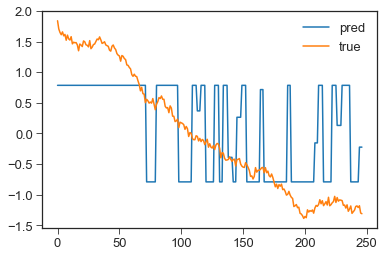

In [31]:
y_pred = RandomSearch.predict(X_test)
rms = np.sqrt(np.sum((y_pred-y_test)**2)/len(y_test))
plt.figure()
plt.plot(y_pred,label="pred")
plt.plot(y_test, label="true")
plt.legend()
plt.show()

### Bayesian optimization NN

In [32]:
from bayes_opt import BayesianOptimization
def NN_CrossValidation(learning_rate_init, nodes_1, nodes_2, data, targets):
    '''nodes contain the given number of nodes in the given layer'''
    estimator = MLPRegressor(random_state=42, learning_rate = 'adaptive', solver='adam', early_stopping=True, max_iter=1000,
                             learning_rate_init=learning_rate_init,
                             hidden_layer_sizes = (nodes_1, nodes_2))
    
    cval = cross_val_score(estimator, data, targets, cv=5, scoring = 'neg_root_mean_squared_error')
    
    return cval.mean()

def optimize_NN(data, targets, pars, n_iter=5):
    """Apply Bayesian Optimization to Decision Tree parameters."""
    
    def crossval_wrapper(learning_rate_init, nodes_1, nodes_2, data=data, targets=targets):
        """Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        return NN_CrossValidation(learning_rate_init=learning_rate_init, 
                                       nodes_1 = int(nodes_1),
                                       nodes_2 = int(nodes_2),
                                       data=data, 
                                       targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=42, 
                                     verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

In [33]:
parameters_BayesianOptimization = {"learning_rate_init": (0.0001, 1), 
                                   "nodes_1": (1, 100),
                                   "nodes_2": (1, 100)
                                  }

BayesianOptimization = optimize_NN(data = X_train, 
                                        targets = y_train, 
                                        pars = parameters_BayesianOptimization, 
                                        n_iter=100)
print(BayesianOptimization.max)

|   iter    |  target   | learni... |  nodes_1  |  nodes_2  |
-------------------------------------------------------------
|  1        | -44.94    |  0.3746   |  95.12    |  73.47    |
|  2        | -1.021    |  0.5987   |  16.45    |  16.44    |
|  3        | -0.8161   |  0.05818  |  86.75    |  60.51    |
|  4        | -2.108    |  0.7081   |  3.038    |  97.02    |
|  5        | -1.403    |  0.7824   |  3.282    |  96.97    |
|  6        | -1.263    |  0.4973   |  3.249    |  97.25    |
|  7        | -0.9397   |  0.007601 |  86.69    |  60.74    |
|  8        | -1.533    |  0.189    |  87.15    |  60.54    |
|  9        | -1.021    |  0.6      |  16.77    |  16.56    |
|  10       | -1.314    |  0.5925   |  3.799    |  97.21    |


C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  11       | -6.127    |  0.4101   |  86.55    |  60.58    |
|  12       | -0.8953   |  0.06983  |  3.513    |  97.48    |
|  13       | -4.164    |  0.8519   |  3.682    |  96.96    |
|  14       | -0.9249   |  0.0001   |  86.93    |  60.63    |
|  15       | -1.023    |  0.3084   |  86.25    |  10.29    |
|  16       | -0.855    |  0.1309   |  3.356    |  96.89    |
|  17       | -1.853    |  0.2683   |  26.27    |  50.94    |
|  18       | -11.63    |  0.6124   |  7.09     |  43.06    |
|  19       | -1.117    |  0.2781   |  3.554    |  97.18    |
|  20       | -195.5    |  0.9457   |  45.69    |  91.12    |
|  21       | -1.679    |  0.611    |  3.638    |  96.51    |
|  22       | -1.024    |  0.5705   |  16.36    |  16.87    |
|  23       | -1.03     |  0.5864   |  16.54    |  16.69    |
|  24       | -2.145    |  0.6004   |  3.638    |  97.57    |
|  25       | -0.9317   |  0.05022  |  86.72    |  60.85    |
|  26       | -2.212    |  0.3033   |  26.15    |  50.95    |
|  27   

C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


|  58       | -0.7939   |  0.0001   |  3.588    |  97.17    |
|  59       | -0.9444   |  0.2189   |  3.147    |  96.39    |
|  60       | -1.029    |  0.9088   |  16.1     |  16.29    |
|  61       | -1.559    |  0.4484   |  15.78    |  16.98    |
|  62       | -0.8939   |  0.06353  |  3.298    |  96.28    |
|  63       | -1.02     |  0.9363   |  16.83    |  16.64    |
|  64       | -1.459    |  0.4686   |  3.347    |  97.13    |
|  65       | -1.047    |  0.4552   |  86.05    |  10.22    |
|  66       | -1.023    |  0.401    |  16.43    |  16.72    |
|  67       | -0.9298   |  0.09818  |  87.1     |  61.09    |
|  68       | -1.022    |  0.3207   |  16.03    |  16.37    |
|  69       | -1.72     |  0.5511   |  16.17    |  17.07    |
|  70       | -0.9952   |  0.2542   |  3.506    |  97.54    |
|  71       | -0.9769   |  0.2724   |  68.27    |  59.66    |
|  72       | -7.142    |  0.6806   |  22.92    |  40.8     |
|  73       | -1.75     |  0.3729   |  91.16    |  12.89    |
|  74   

C:\Users\jonat\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


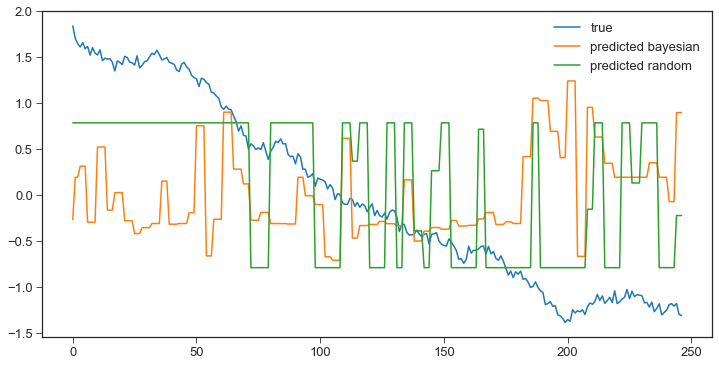

RMS = 1.213


In [34]:
model = MLPRegressor(random_state=42, learning_rate = 'adaptive', solver='adam', early_stopping=True,
                         learning_rate_init=BayesianOptimization.max["params"]["learning_rate_init"],
                         hidden_layer_sizes = (int(BayesianOptimization.max["params"]["nodes_1"]), 
                                               int(BayesianOptimization.max["params"]["nodes_2"]))
                    )
model.fit(X_train, y_train)

# make predictions for test data
y_pred_mlp = model.predict(X_test)

# evaluate predictions
plt.figure(figsize=(12,6))
plt.plot(y_test,label="true")
plt.plot(y_pred_mlp, label="predicted bayesian")
plt.plot(y_pred, label="predicted random")
plt.legend()
plt.show()

rms = np.sqrt(np.sum((y_test-y_pred_mlp)**2)/len(y_test))
print(f"RMS = {rms:.3f}")

## Linear Regression

In [35]:
reg = LinearRegression().fit(X_train, y_train)
y_pred_linear = reg.predict(X_test)

In [36]:
LSTM_res = np.loadtxt("LSTM_predicted.txt")

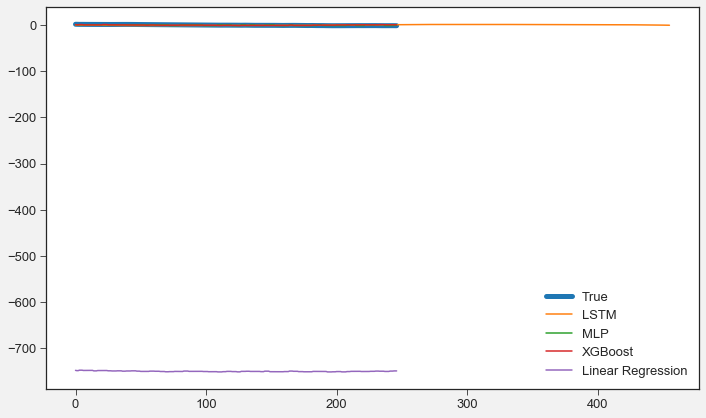

In [37]:
fig = plt.figure(figsize=(10,6))
plt.plot(y_test, label="True", lw=5.)
plt.plot(LSTM_res,label="LSTM")
plt.plot(y_pred, label="MLP")
plt.plot(y_pred_xg, label="XGBoost")
plt.plot(y_pred_linear- 750, label="Linear Regression")
fig.patch.set_facecolor("#f2f2f2")
plt.legend()
plt.tight_layout()
plt.show()

if save:
    fig.savefig(f"figs/Final_result_test_on_{test_on}.png", dpi=500, facecolor=fig.get_facecolor())

ValueError: operands could not be broadcast together with shapes (247,) (456,) 

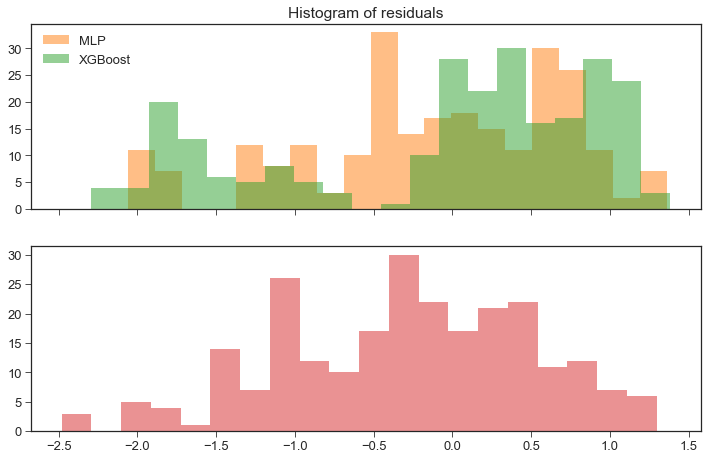

In [38]:
fig, axes = plt.subplots(2,1, figsize=(12,7.5), sharex=True)
ax = axes[0]
ax.set_title("Histogram of residuals")
ax.hist(y_test - y_pred, bins=20, label="MLP", alpha=.5, color="C1")
ax.hist(y_test - y_pred_xg, bins=20, label="XGBoost", alpha=.5, color="C2")
ax.legend()
ax = axes[1]
ax.hist(y_test - y_pred_linear, bins=20, label="Linear Regression",alpha=.5, color="C3")
ax.hist(y_test - LSTM_res, bins=20, label="LSTM", alpha=.5, color="C4")
ax.legend()
plt.show()